In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [2]:
# Tải dữ liệu cổ phiếu
stock = "POWERGRID.NS"
start = "2000-01-01"
end = "2024-11-01"
df = yf.download(stock, start=start, end=end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
df.dropna(inplace=True)  # Xóa giá trị NaN

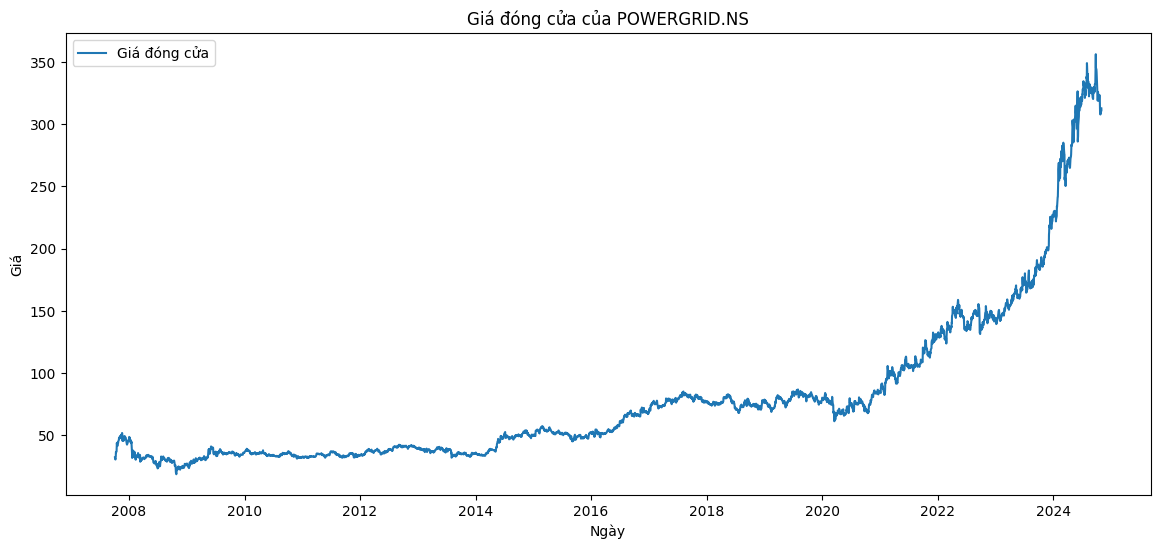

In [4]:
# Trực quan hóa dữ liệu
def plot_stock_data(df):
    plt.figure(figsize=(14, 6))
    plt.plot(df['Close'], label='Giá đóng cửa')
    plt.title(f'Giá đóng cửa của {stock}')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')
    plt.legend()
    plt.show()

plot_stock_data(df)

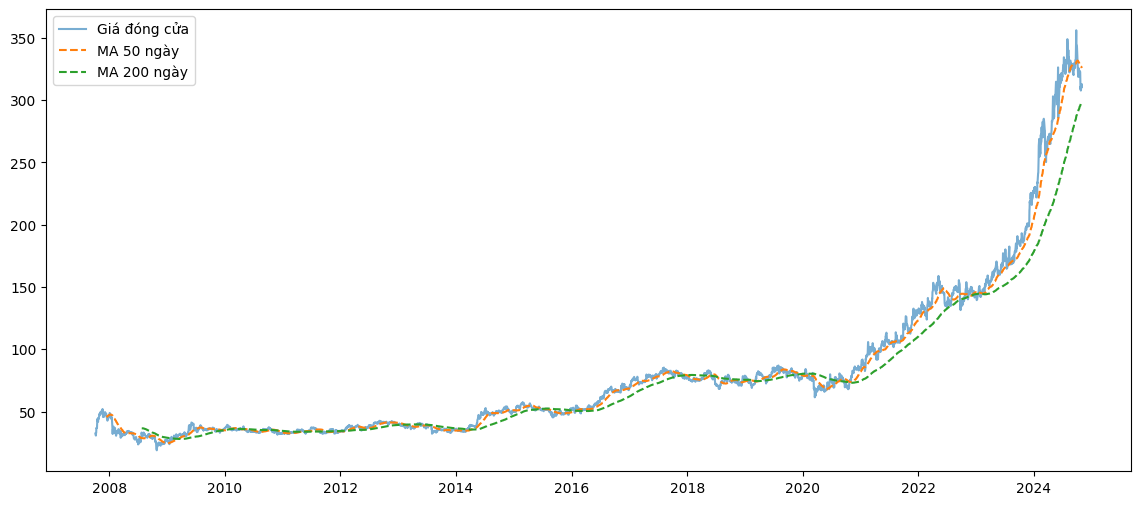

In [5]:
# Thêm đường trung bình động (MA)
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Giá đóng cửa', alpha=0.6)
plt.plot(df['MA50'], label='MA 50 ngày', linestyle='dashed')
plt.plot(df['MA200'], label='MA 200 ngày', linestyle='dashed')
plt.legend()
plt.show()

In [7]:
# Chuẩn bị dữ liệu cho mô hình LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

In [8]:
# Tạo tập dữ liệu train/test
time_step = 60
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Định nghĩa mô hình với Input
inputs = Input(shape=(time_step, 1))
x = LSTM(50, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = LSTM(50, return_sequences=False)(x)
x = Dropout(0.2)(x)
x = Dense(25)(x)
outputs = Dense(1)(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()  # Kiểm tra kiến trúc mô hình



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 60, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0027
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.2395e-04
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 8.8780e-05
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 8.1909e-05
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 7.8022e-05
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.2900e-05
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 6.8880e-05
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.3712e-05
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 6.0081e-05
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 5.6733e-05
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 5.6426e-05
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 5.9871e-05
Epoch 13/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 5.4634e-05
Epoch 14/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 5.

In [12]:
# Dự đoán giá
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step 


In [13]:
# Đánh giá mô hình
rmse = np.sqrt(mean_squared_error(df['Close'][train_size + time_step + 1:], predictions))
print(f'RMSE: {rmse}')

RMSE: 6.841262713768477


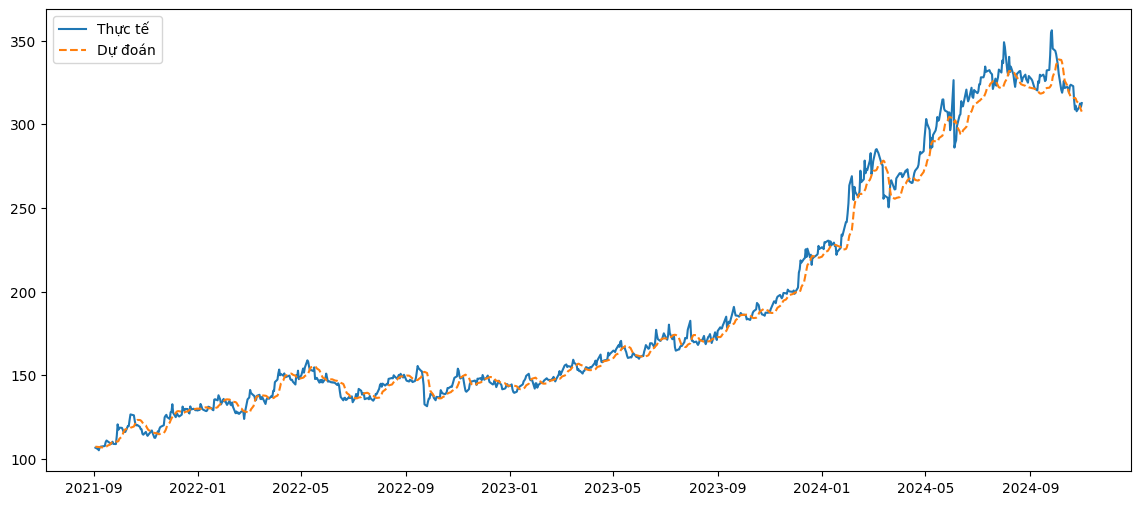

In [14]:
# Vẽ biểu đồ kết quả
plt.figure(figsize=(14, 6))
plt.plot(df.index[train_size + time_step + 1:], df['Close'][train_size + time_step + 1:], label='Thực tế')
plt.plot(df.index[train_size + time_step + 1:], predictions, label='Dự đoán', linestyle='dashed')
plt.legend()
plt.show()